## Exploratory Data Analysis

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_cleaning.ipynb)
- Exploratory Data Analysis (this notebook)
- [Modeling](./03_modeling.ipynb)

**In this notebook, you'll find:**
- Feature engineering
- Data exploration
- Visualizations

In [1]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
gap = pd.read_csv('../data/aggregated_df_cleaned.csv')

gap['id'].fillna('NA', inplace=True)
gap.head()

,geo,year,income_per_person,population,life_expectancy,id,region,sub-region
0,Afghanistan,1800,603,3280000,28.200,AF,Asia,Southern Asia
1,Afghanistan,1801,603,3280000,28.200,AF,Asia,Southern Asia
2,Afghanistan,1802,603,3280000,28.200,AF,Asia,Southern Asia
3,Afghanistan,1803,603,3280000,28.200,AF,Asia,Southern Asia
4,Afghanistan,1804,603,3280000,28.200,AF,Asia,Southern Asia


--- 
### Feature Engineering

Before we begin exploring the data, we'll be engineering a few features that we believe will add value to our analysis. These features are created through two functions. 

The first will calculate the upper and lower 20% bounds by year for the selected column, then add these quantile values to two additional columns corresponding with the given year in each row.

The second function looks at the value in our original column, then compares it to the upper and lower bounds seen in our new quantile features and assigns a category based on the relative relationship to our margins.

In [3]:
def quantile_cols(df, feature):    
    df[feature + '_low_q'] = [df[df['year'] == i][feature].quantile(0.2) for i in df['year']]
    df[feature + '_high_q'] = [df[df['year'] == i][feature].quantile(0.8) for i in df['year']]

    feature_s = feature.replace('_', ' ').title()
    
    print(f'{feature_s} quantile columns added successfully!')

In [4]:
def category_cols(df, feature):
    df[feature + '_category'] = ''

    for a, b, c, d in zip(df[feature + '_low_q'], df[feature + '_high_q'], df[feature], df.index):
        if c <= a:
            df.loc[d, feature + '_category'] = 'low'
        elif c >= b: 
            df.loc[d, feature + '_category'] = 'high'
        else:
            df.loc[d, feature + '_category'] = 'average'

    feature_s = feature.replace('_', ' ').title()
    
    print(f'{feature_s} category column added successfully!')

We'll now call the functions on our three numeric features in the dataset (excluding year), and will obtain our original dataframe with nine supplementary features. 

In [5]:
quantile_cols(gap, 'income_per_person')
category_cols(gap, 'income_per_person')

Income Per Person quantile columns added successfully!
Income Per Person category column added successfully!


In [6]:
quantile_cols(gap, 'population')
category_cols(gap, 'population')

Population quantile columns added successfully!
Population category column added successfully!


In [7]:
quantile_cols(gap, 'life_expectancy')
category_cols(gap, 'life_expectancy')

Life Expectancy quantile columns added successfully!
Life Expectancy category column added successfully!


In [8]:
gap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37449 entries, 0 to 37448
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   geo                         37449 non-null  object 
 1   year                        37449 non-null  int64  
 2   income_per_person           37449 non-null  int64  
 3   population                  37449 non-null  int64  
 4   life_expectancy             37449 non-null  float64
 5   id                          37449 non-null  object 
 6   region                      37449 non-null  object 
 7   sub-region                  37449 non-null  object 
 8   income_per_person_low_q     37449 non-null  float64
 9   income_per_person_high_q    37449 non-null  float64
 10  income_per_person_category  37449 non-null  object 
 11  population_low_q            37449 non-null  float64
 12  population_high_q           37449 non-null  float64
 13  population_category         374

In [9]:
gap.to_csv('../data/gap_features_engineered.csv', index=False)

---
### EDA

This exploratory analysis of our dataset will be broken down into four sections:
1. First, we'll look into more **general** questions and summarizations of the data as a whole.
2. Next, we'll aggregate based on year only and look at overall **global** metrics.
3. We will then break down our data by **continent** and compare values across geographies, assigned categories, and time.
4. Finally, we will explore the **countries** within our dataset and examine our top *n* countries based on specific questions and categories.

As noted above, we've created quantile and categorical columns for a few of our original features. The assigned category columns will appear several times throughout our explorative inspection below. 

For the sake of clarity, 'Low' will appear anywhere that a country's given value was less than or equal to the global (pertaining to our data, specifically) 20th quantile in the associated year. 

'High' refers to any value that was greater than or equal to the global 80th quantile (greater than 80% of all other countries in the given year). 

'Average' occurs when the value falls anywhere between these two.

---

#### General

##### What is the mean life expectancy across the entire dataset?

In [10]:
gap['life_expectancy'].mean()

43.20531068920399

- The average life expectancy across all countries and years in our dataset is 43.2 years old.

##### What is the mean life expectancy for each category?

In [40]:
gap.groupby('life_expectancy_category')['life_expectancy'].mean().sort_values(ascending=False)

life_expectancy_category
high      53.306
average   43.113
low       33.574
Name: life_expectancy, dtype: float64

- Though these are generalized values, we can already see large gaps in life expectancy based on the assigned category of each country in a given year. 

##### What is the mean population for each life expectancy category?

In [11]:
gap.groupby('life_expectancy_category')['population'].mean().sort_values(ascending=False)

life_expectancy_category
average   14931189.769
high      13855662.139
low       13526289.076
Name: population, dtype: float64

- We were curious to see if there may be a connection between more populous countries and lower life expectancy due to limited health/ecomonic resources. We cannot make any definitive statements, but our dataset does not appear to support this theory. 

- In the plot below, we can see that our 'Low' life expectancy category countries have the smallest mean population compared to the other two categories.

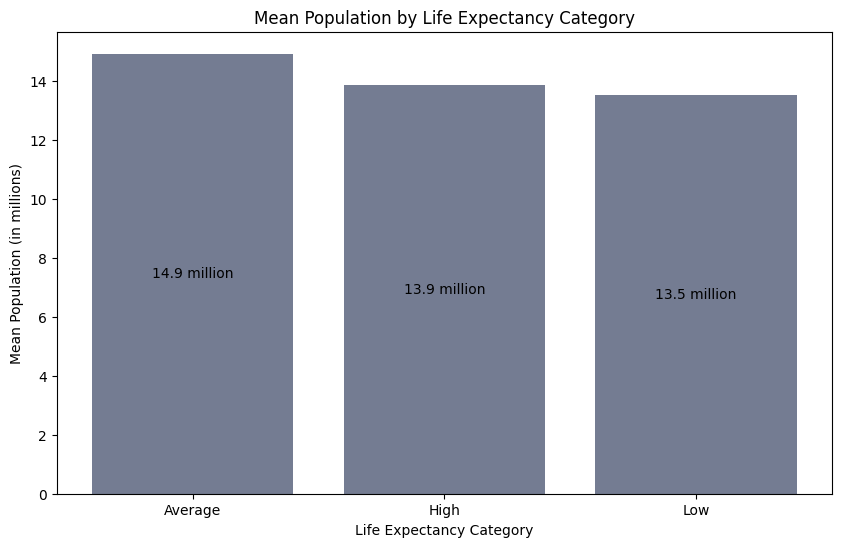

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

pop_life_exp_category_plot = ax.bar(x = sorted(gap['life_expectancy_category'].unique()), height = [i/1_000_000 for i in gap.groupby('life_expectancy_category')['population'].mean().sort_values(ascending=False)], color = '#747C92')
ax.bar_label(pop_life_exp_category_plot, labels = [(str(round(i, 1)) + ' million') for i in [i/1_000_000 for i in gap.groupby('life_expectancy_category')['population'].mean().sort_values(ascending=False)]],  label_type='center')
ax.set(title='Mean Population by Life Expectancy Category', xlabel='Life Expectancy Category', xticks=[0, 1, 2], xticklabels=[i.title() for i in sorted(gap['life_expectancy_category'].unique())], ylabel='Mean Population (in millions)')
plt.show();

##### What is the mean income per person for each life expectancy category?

In [13]:
gap.groupby('life_expectancy_category')['income_per_person'].mean().sort_values(ascending=False)

life_expectancy_category
high      10022.841
average    3848.465
low        1313.436
Name: income_per_person, dtype: float64

- When we look at income per person grouped by life expectancy category, we do see more conclusive results. 

- There is a 153.66% difference between the mean incomes of our 'Low' and 'High' life expectancy countries. This is not unexpected, but does show the stark contrast in income and personal wealth when we separate our data by life expectancy category.

- This [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4866586/) further examines the relationship between income and life expectancy. 

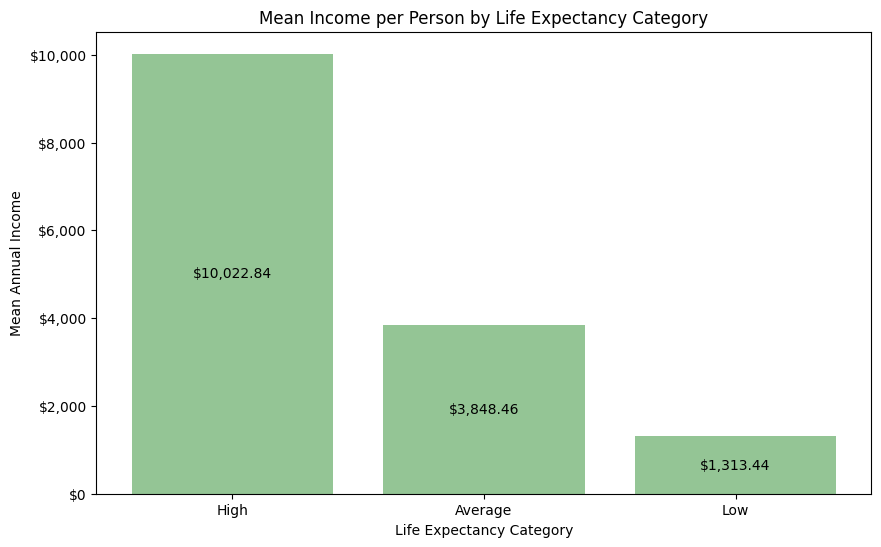

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

income_life_exp_category_plot = ax.bar(x = sorted(gap['life_expectancy_category'].unique()), height = gap.groupby('life_expectancy_category')['income_per_person'].mean().sort_values(ascending=False), color = '#94C595')
ax.bar_label(income_life_exp_category_plot, labels = ['${:,.2f}'.format(i) for i in gap.groupby('life_expectancy_category')['income_per_person'].mean().sort_values(ascending=False)],  label_type='center')
ax.set(title='Mean Income per Person by Life Expectancy Category', xlabel='Life Expectancy Category', xticks=[0, 1, 2], xticklabels=['High', 'Average', 'Low'], ylabel='Mean Annual Income')
ax.yaxis.set_major_formatter('${x:,.0f}')
plt.show();

##### Inversely, what is the mean life expectancy for each income per person category?

In [15]:
gap.groupby('income_per_person_category')['life_expectancy'].mean().sort_values(ascending=False)

income_per_person_category
high      50.999
average   42.632
low       37.062
Name: life_expectancy, dtype: float64

- These results are consistent with what we saw above - countries with greater income per capita typically see increased life expectancy of their inhabitants. 

- Here, there is a 31.65% difference between our 'Low' and 'High' category means.

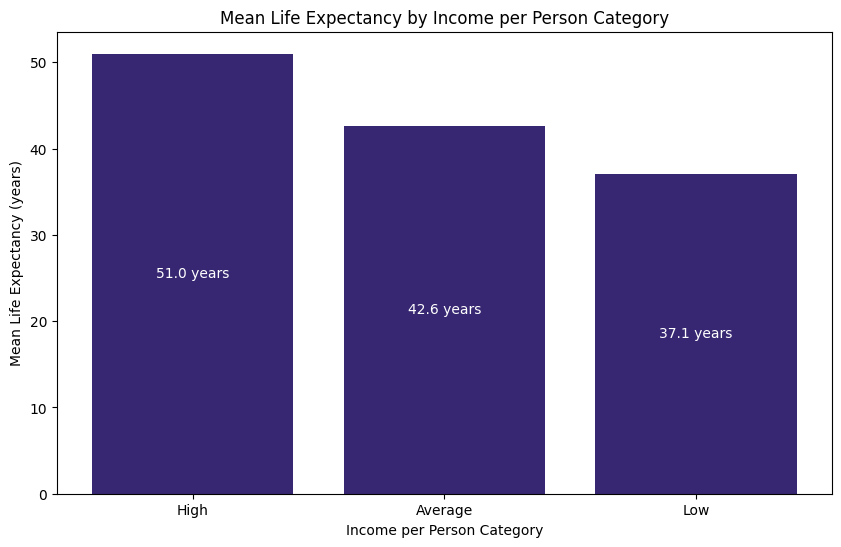

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

income_life_exp_category_plot = ax.bar(x = sorted(gap['life_expectancy_category'].unique()), height = gap.groupby('income_per_person_category')['life_expectancy'].mean().sort_values(ascending=False), color = '#372772')
ax.bar_label(income_life_exp_category_plot, labels = [str(round(i, 1)) + ' years' for i in gap.groupby('income_per_person_category')['life_expectancy'].mean().sort_values(ascending=False)],  label_type='center', color = 'white')
ax.set(title='Mean Life Expectancy by Income per Person Category', xlabel='Income per Person Category', xticks=[0, 1, 2], xticklabels=['High', 'Average', 'Low'], ylabel='Mean Life Expectancy (years)')
plt.show();

---

#### Global

##### How did overall life expectancy change over time?

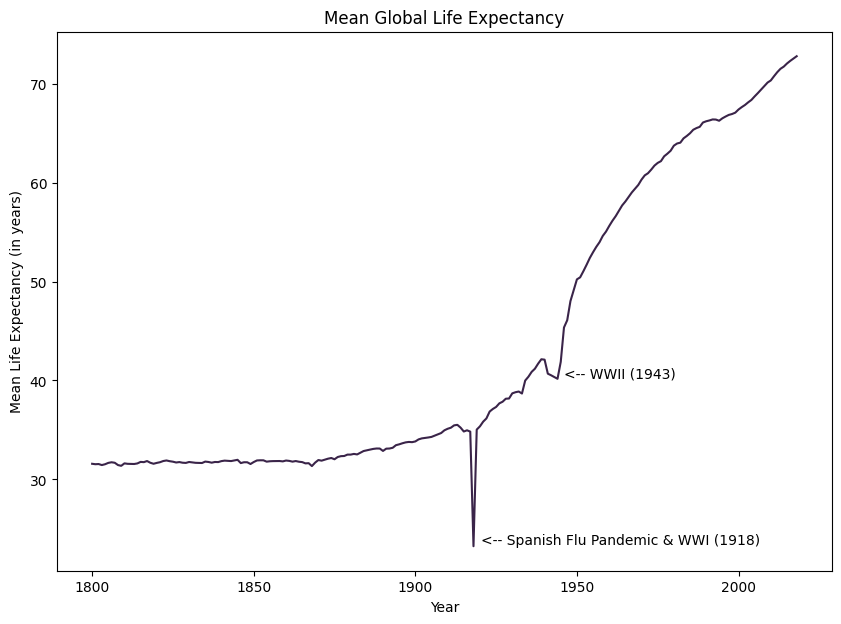

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(gap['year'].unique(), gap.groupby('year')['life_expectancy'].mean(), color = '#3A2449')
plt.title('Mean Global Life Expectancy')
plt.xlabel('Year')
plt.ylabel('Mean Life Expectancy (in years)')
plt.annotate('<-- Spanish Flu Pandemic & WWI (1918)', (305, 19), xycoords='axes points')
plt.annotate('<-- WWII (1943)', (365, 139), xycoords='axes points');

- We can see above that there has been a steady ascent in mean global life expectancy over time, with distinct exceptions visible in the early 1900s, and again about 25 years later.

- These two dips coincide with the 1918 Great Influenza that killed upwards of 25 million people across the globe, and the duration of WWII (1939-1945), in which an estimated 70-85 million people died. 

##### Similarly, how did the mean income per person change between the 19th and 21st centuries?

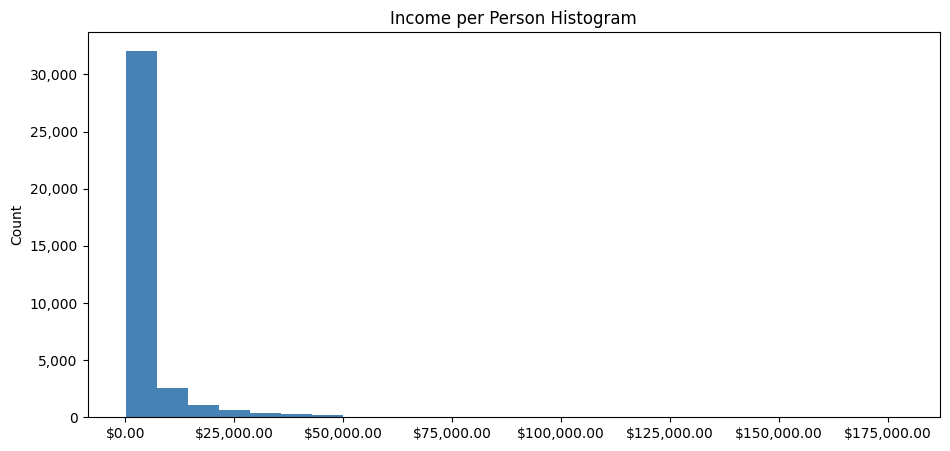

In [18]:
fig, ax = plt.subplots(figsize=(11,5))

ax.hist(gap['income_per_person'], bins=25, color='steelblue')
ax.set(title = 'Income per Person Histogram', ylabel='Count')
ax.xaxis.set_major_formatter('${x:,.2f}')
ax.yaxis.set_major_formatter('{x:,.0f}');

- Before we plot the mean income per person over time, we'd like to address the distribution of the income per person feature in our dataset. We can see a clear right skew in the histogram above.

- While we can't force a normal distribution, we plan to plot the log values of the mean income per person alongside the original values. This will allow us to view the normalized scale next to the unaltered axis, and lead to increased interpretability of our income per person from 1800 to 2018. 

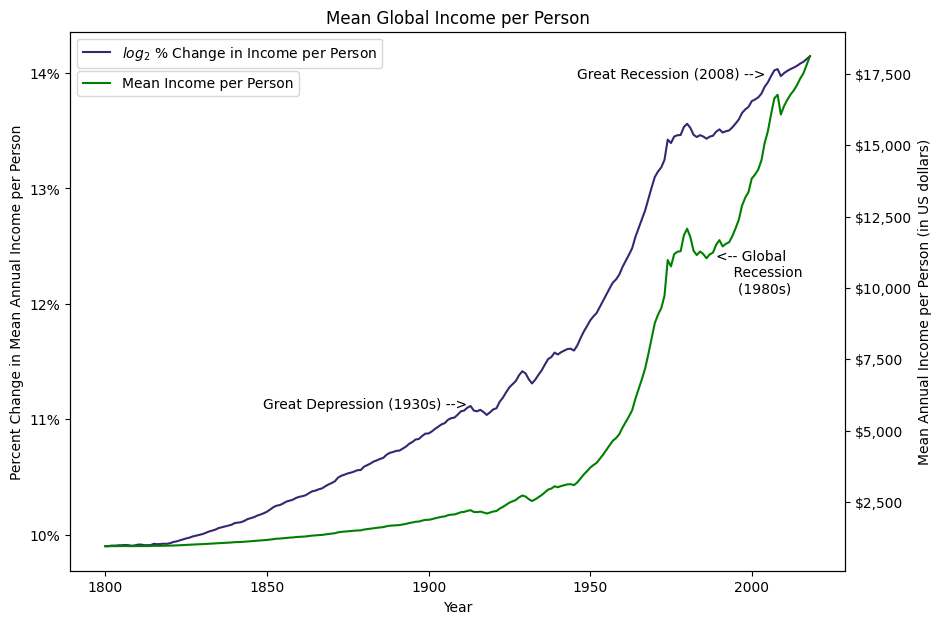

In [19]:
fig, ax = plt.subplots(figsize=(10,7))

ax2 = ax.twinx()
ax.plot(gap['year'].unique(), np.log2(gap.groupby('year')['income_per_person'].mean()), color = '#372772', label=r'$log_{2}$ % Change in Income per Person')
ax.set(title= 'Mean Global Income per Person', xlabel='Year', ylabel='Percent Change in Mean Annual Income per Person')
ax.yaxis.set_major_formatter('{x:,.0f}%')
ax.annotate('Great Recession (2008) -->', (365, 355), xycoords='axes points')
ax.annotate('<-- Global\n    Recession\n     (1980s)', (465, 200), xycoords='axes points')
ax.annotate('Great Depression (1930s) -->', (139, 117), xycoords='axes points')
ax2.plot(gap['year'].unique(), gap.groupby('year')['income_per_person'].mean(), color = 'green', label='Mean Income per Person')
ax2.yaxis.set_major_formatter('${x:,.0f}')
ax2.set(ylabel='Mean Annual Income per Person (in US dollars)')
ax.legend()
ax2.legend(loc = 'upper left', bbox_to_anchor=(0, .94));

- Our global income per person plot above follows a similar curve to our global life expectancy chart. There is a stable increase in the mean income per person over time, with three noticeable drops. 
1. **The Great Depression (1929 - 1939)** was a severe economic downturn that affected many countries across the world. In our chart, we can see that the log<sub>2</sub> line shows a more discernible impact on the mean income per person than is seen in our non-logged plot. 

2. **The Global Recession (1980 - 1983)** was partially triggered by the 1979 oil crisis that severely disrupted the global oil supply and led to climbing inflation and interest rates. Unemployment hit 11% during this time, which likely contributed to the decline in income per person.

3. **The Great Recession (2007 - 2009)** began as a result of the burst of the US housing market bubble, and led to many mortgage-backed securities rapidly decreasing in value. Described as the worst economic downturn since The Great Depression, this led to many new fiscal and regulatory policy changes at the federal level. 
    - We also notice that the effects of this global recession are more pronounced in the non-log<sub>2</sub> plot, implying that when normalized, the relative significance may have been less than those of the prior two events.

##### Can we look at mean income per person and life expectancy for all countries in a given year?

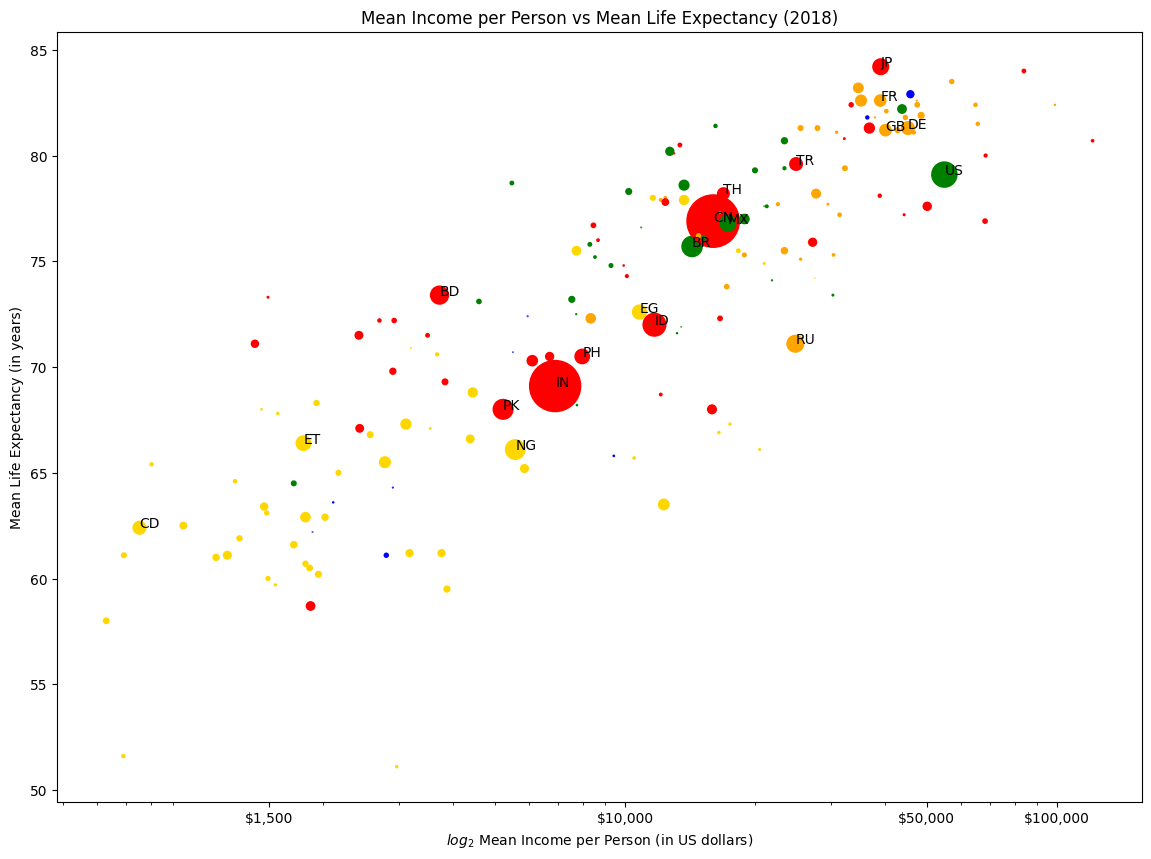

In [20]:
most_recent = gap[gap['year'] == 2018]

fig, ax = plt.subplots(figsize=(14,10))

# Adding colors based on region
reg_colors = dict(zip(gap['region'].unique(), ['red', 'orange', 'gold', 'green', 'blue']))

ax.scatter(most_recent['income_per_person'], most_recent['life_expectancy'], s=(most_recent['population']/1_000_000), c=most_recent['region'].map(reg_colors))

# Country abbreviations for the 15 with the largest population
top_pop = most_recent.sort_values(by='population', ascending=False).head(20)

for i, (inc, life, country) in enumerate(zip(top_pop['income_per_person'], top_pop['life_expectancy'], top_pop['id'])):
    ax.annotate(country, (inc, life))

plt.title('Mean Income per Person vs Mean Life Expectancy (2018)')
plt.xlabel(r'$log_{2}$ Mean Income per Person (in US dollars)')
plt.ylabel('Mean Life Expectancy (in years)')
plt.xscale('log')
ax.set(xticks=[1_500, 10_000, 50_000, 100_000], xticklabels=['$1,500', '$10,000', '$50,000', '$100,000'])
plt.show();

- Yes, we can! Above is the logged (with base 2) mean income per person and mean life expectancy for each country in the most recent year of our dataset (2018).
- The bubbles are sized based on the country's population in 2018. 
- The top 20 countries with the largest populations are annotated with their abbreviations to provide additional context to the plot.

##### Can we plot the same as above, but dynamically so that it changes for each year and allows us to compare relative growth over time? And can we add filters for further customization?

- We absolutely can! To view this dynamic plot, please visit [this link](https://public.tableau.com/app/profile/cynthia.rodriguez6815/viz/GapminderRecreation_16710692756720/Gapminder).

---

#### Continental

##### What is the mean life expectancy for each continent across all years?

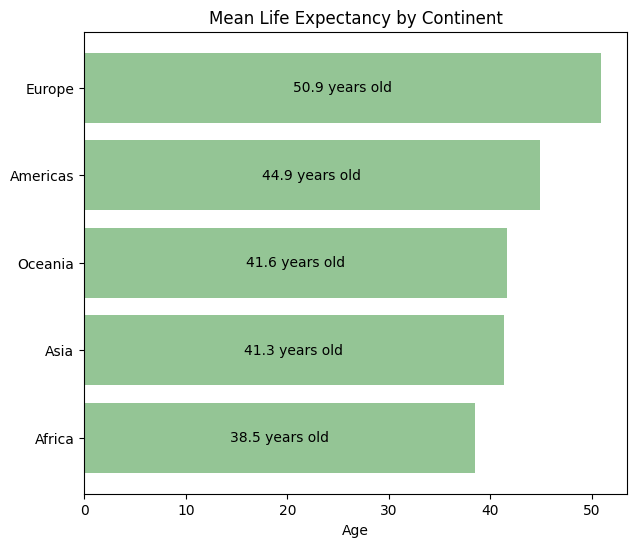

In [21]:
life_exp_by_cont = pd.DataFrame(gap.groupby('region')['life_expectancy'].mean().sort_values(ascending = False))

fig, ax = plt.subplots(figsize=(7,6))

cont_life_exp_plot = ax.barh(width = life_exp_by_cont['life_expectancy'][::-1], y = life_exp_by_cont.index[::-1], color= '#94C595')
ax.bar_label(cont_life_exp_plot, labels = [(str(round(i,1)) + ' years old') for i in life_exp_by_cont['life_expectancy']][::-1], label_type='center')
ax.set(title='Mean Life Expectancy by Continent', xlabel='Age')
plt.show();

- Though this is averaged across all years in our dataset, there is a 12 year difference between our highest- and lowest-value continents.

##### Are we able to provide additional context around the life expectancy categories seen most often in each continent?

In [22]:
cont_life_exp_categories = pd.DataFrame()

for cont in list(gap['region'].unique()):
    life_exp_temp_df = pd.DataFrame(gap[gap['region'] == cont].groupby('year')['life_expectancy_category'].value_counts(ascending=False))
    life_exp_temp_df.index.names = ['year', 'life_exp_category']
    life_exp_temp_df.reset_index(inplace=True)

    most_common_life_exp_cat = pd.DataFrame(life_exp_temp_df.groupby('year')['life_expectancy_category'].nlargest(1)).reset_index()
    most_common_life_exp_cat[cont + '_frequent_category'] = [life_exp_temp_df['life_exp_category'][i] for i in list(most_common_life_exp_cat['level_1'])]
    most_common_life_exp_cat.drop(columns=['level_1', 'life_expectancy_category'], inplace=True)
    if cont != 'Asia':
        most_common_life_exp_cat.drop(columns='year', inplace=True)

    cont_life_exp_categories = pd.concat([cont_life_exp_categories, most_common_life_exp_cat], axis=1)

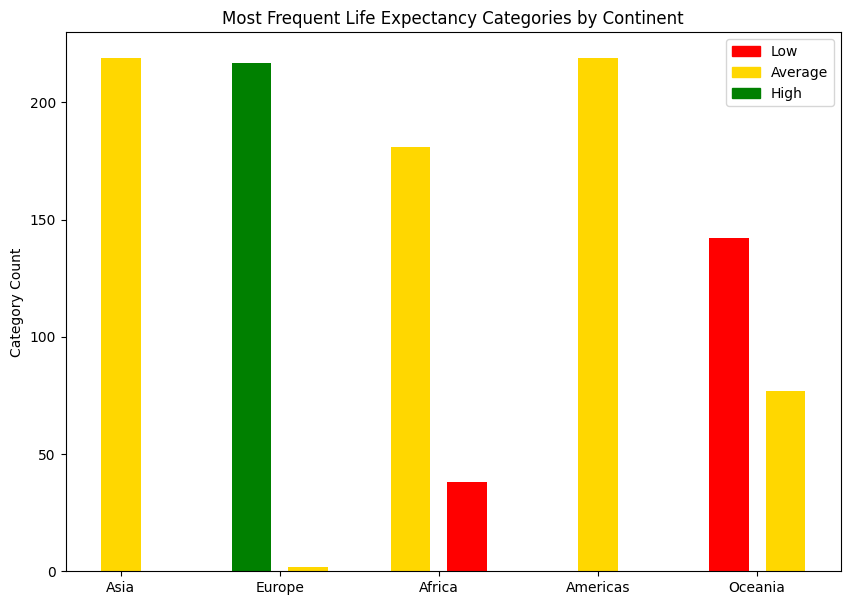

In [23]:
cont_cols = [col for col in cont_life_exp_categories.columns if col != 'year']
labels = [i.replace('_frequent_category', '') for i in cont_cols]

width = 0.35
colors = {'Low': 'red', 'Average': 'gold', 'High': 'green'}
legend_labels = colors.keys()
handles = [plt.Rectangle((0,0),1,1, color=colors[key]) for key in legend_labels]

fig, ax = plt.subplots(figsize=(10,7))

for i in range(5):
    if len(cont_life_exp_categories[cont_cols[i]].value_counts().values) > 1:
        ax.bar(np.array([.7,1.2])+1.4*i, 
        cont_life_exp_categories[cont_cols[i]].value_counts().values,
        width=width, 
        label=labels[i],
        color = ['red' if x == 'low' else 'gold' if x == 'average' else 'green' for x in cont_life_exp_categories[cont_cols[i]].value_counts().keys()])
    else:
        ax.bar(.95+1.4*i, 
        cont_life_exp_categories[cont_cols[i]].value_counts().values,
        width=width, 
        label=labels[i],
        color = ['red' if x == 'low' else 'gold' if x == 'average' else 'green' for x in cont_life_exp_categories[cont_cols[i]].value_counts().keys()])

ax.set(title='Most Frequent Life Expectancy Categories by Continent', ylabel='Category Count')
ax.set_xticks([.95+1.4*i for i in range(5)], labels)
ax.legend(handles, legend_labels);

- What we're seeing above is an aggregated view of the most common life expectancy categories for each continent. To find this, we looked at all countries in each continent and their assigned life expectancy categories for a given timeframe. From there, we found the category that occurred most often among the countries for each year, and designated said category as the continent's overall category for the year.
- A few quick observations:
    - Asia and the Americas' most frequent category was 'average' for all years.
    - Europe is the only continent that had 'high' as a prevalent life expectancy category.
    - Oceania is made up of just nine countries (in our dataset), but saw 'low' as its most common life expectancy category for many of the 219 years in our data.
    - Africa, like Asia and the Americas, saw 'average' most often, but also had a small range of years in which 'low' was the predominant category assignment amongst its countries.

##### What is the mean income per person for each continent across all years?

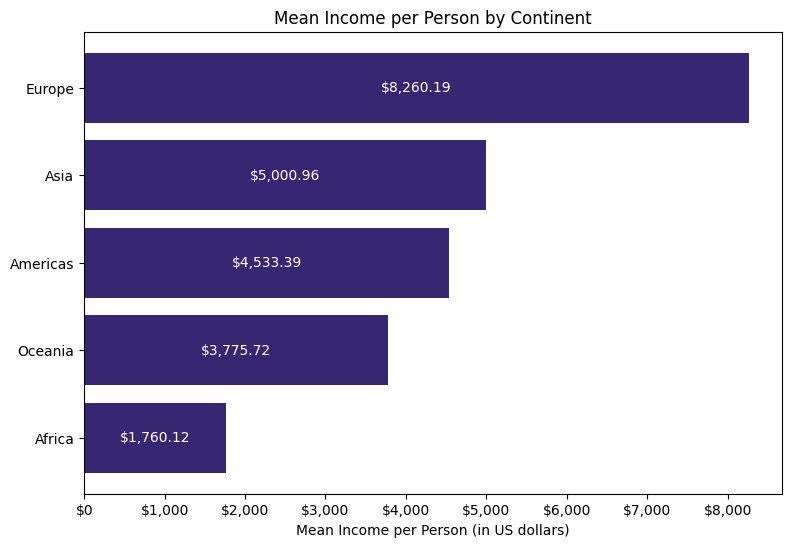

In [24]:
inc_by_cont = pd.DataFrame(gap.groupby('region')['income_per_person'].mean().sort_values(ascending = False))

fig, ax = plt.subplots(figsize=(9,6))

cont_inc_plot = ax.barh(width = inc_by_cont['income_per_person'][::-1], y = inc_by_cont.index[::-1], color= '#372772')
ax.bar_label(cont_inc_plot, labels = ['${:,.2f}'.format(i) for i in inc_by_cont['income_per_person']][::-1], label_type='center', color = 'white')
tick_vals = list(range(0, 9000, 1000))
ax.set(title='Mean Income per Person by Continent', xlabel='Mean Income per Person (in US dollars)', xticks=tick_vals, xticklabels=['${:,.0f}'.format(i) for i in tick_vals])
plt.show();

- These values are averaged over all 200+ years in our data, and are likely significantly lower than modern-day amounts. 
- That being said, there is a wide gap between our highest and lowest mean values.
- It's possible that a handful of high- or low- income countries may be skewing the continental data. We'll dive deeper into that during our country-focused analysis. 

##### What is the median income per person for each continent across all years?

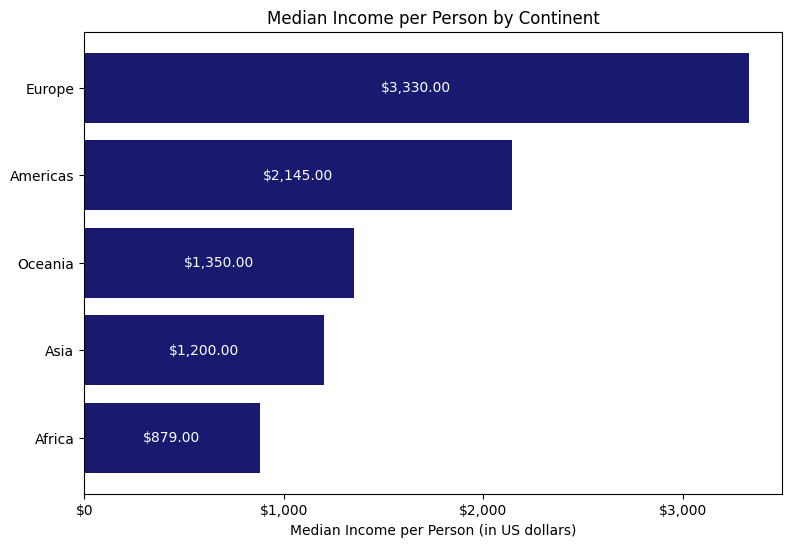

In [25]:
med_inc_by_cont = pd.DataFrame(gap.groupby('region')['income_per_person'].median().sort_values(ascending = False))

fig, ax = plt.subplots(figsize=(9,6))

med_cont_inc_plot = ax.barh(width = med_inc_by_cont['income_per_person'][::-1], y = med_inc_by_cont.index[::-1], color= 'midnightblue')
ax.bar_label(med_cont_inc_plot, labels = ['${:,.2f}'.format(i) for i in med_inc_by_cont['income_per_person']][::-1], label_type='center', color = 'white')
tick_vals = list(range(0, 4000, 1000))
ax.set(title='Median Income per Person by Continent', xlabel='Median Income per Person (in US dollars)', xticks=tick_vals, xticklabels=['${:,.0f}'.format(i) for i in tick_vals])
plt.show();

- We can see that all values have decreased quite a bit, but the gap remains between our highest and lowest continent amounts.
- Moving forward, we'll be looking at both mean and median when analyzing income per person to ensure a comprehensive perspective in our exploration of the data.

We'd like to look at how population, income per person, and life expectancy changed over time for each continent. Here are a few examples of questions we aim to answer:
- Did some continents see larger population booms than others? 
- Were any more affected than others during the Spanish Flu pandemic of the early 1900s? 
- How has income per capita increased or decreased, and does geography play a role?

##### How has mean income per person changed for each continent over time?

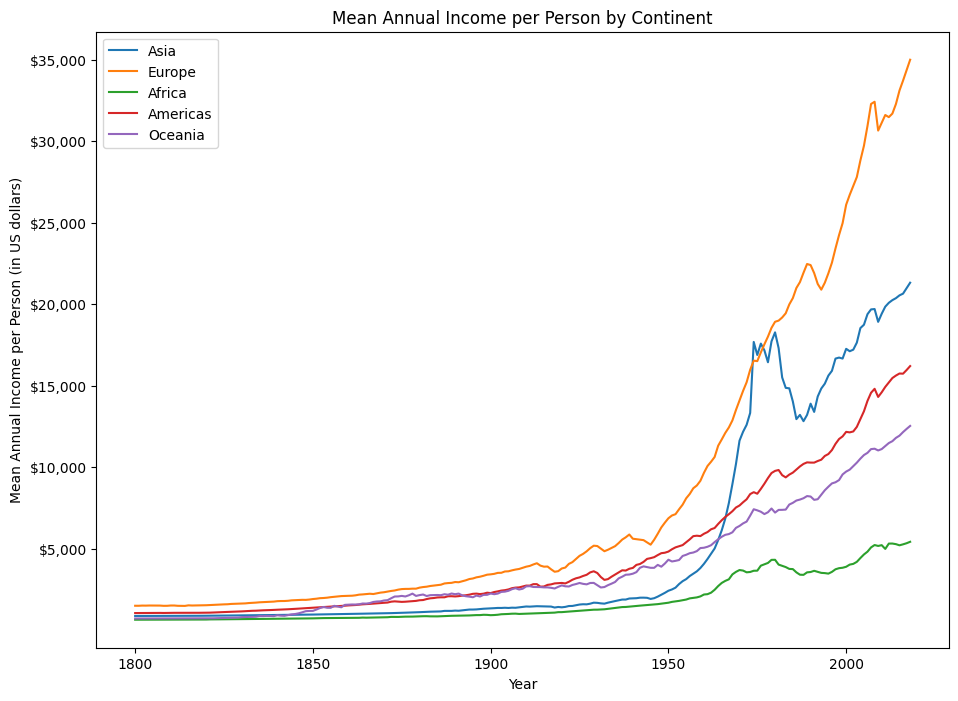

In [26]:
fig, ax = plt.subplots(figsize=(11,8))

for continent in gap['region'].unique():
    plt.plot(cont_life_exp_categories['year'], gap[gap['region'] == continent].groupby('year')['income_per_person'].mean(), label=continent)
    
plt.title('Mean Annual Income per Person by Continent')
plt.xlabel('Year')
plt.ylabel('Mean Annual Income per Person (in US dollars)')
tick_vals = [5_000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000]
plt.yticks(ticks= tick_vals, labels=['${:,.0f}'.format(i) for i in tick_vals])
plt.legend();

- Europe has seen near-uninterrupted growth in its mean income per person, at a rate that is not matched by any of the other continents.
- Asia has a somewhat surprising plot, with a rapid increase around the 70s and a subsequent sharp decline. 
- Africa looks to have experienced much less growth over time, with a little over 30% of its population living under the poverty line in 2018 (9x the global average). 

##### Now looking at median income per person over time.

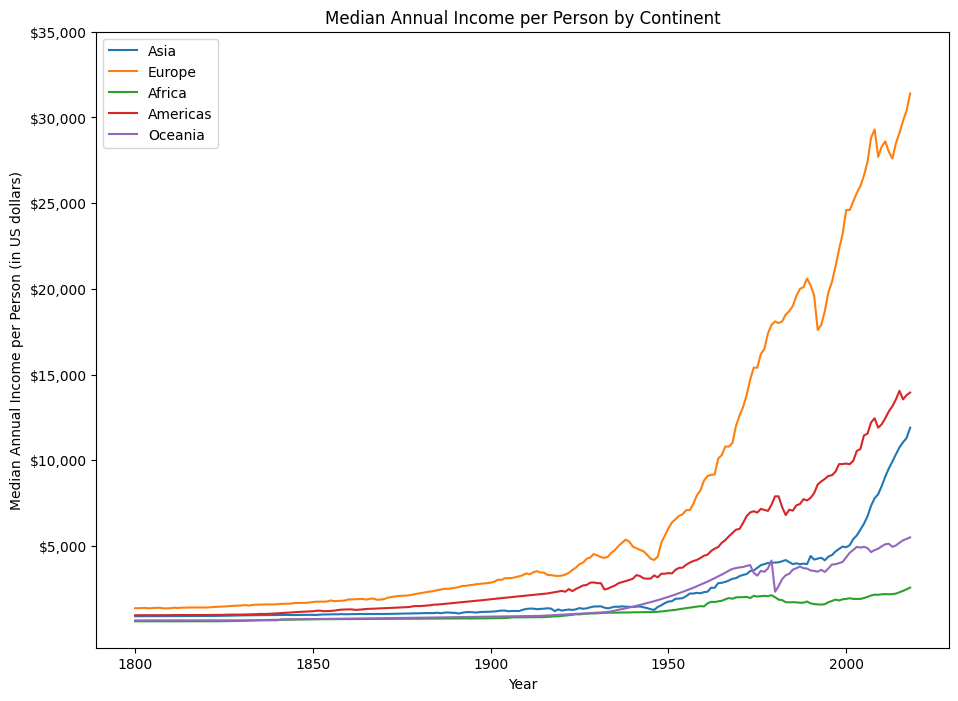

In [27]:
fig, ax = plt.subplots(figsize=(11,8))

for continent in gap['region'].unique():
    plt.plot(cont_life_exp_categories['year'], gap[gap['region'] == continent].groupby('year')['income_per_person'].median(), label=continent)
    
plt.title('Median Annual Income per Person by Continent')
plt.xlabel('Year')
plt.ylabel('Median Annual Income per Person (in US dollars)')
tick_vals = [5_000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000]
plt.yticks(ticks= tick_vals, labels=['${:,.0f}'.format(i) for i in tick_vals])
plt.legend();

- When we look at median instead of mean, Europe's linear growth looks roughly the same. However, our other continents are showing much slower rates of increase. 
- The Americas surpassed Asia to rank 2nd in median income per person (by a small margin).

##### How has the mean life expectancy been affected in each continent after critical global events?

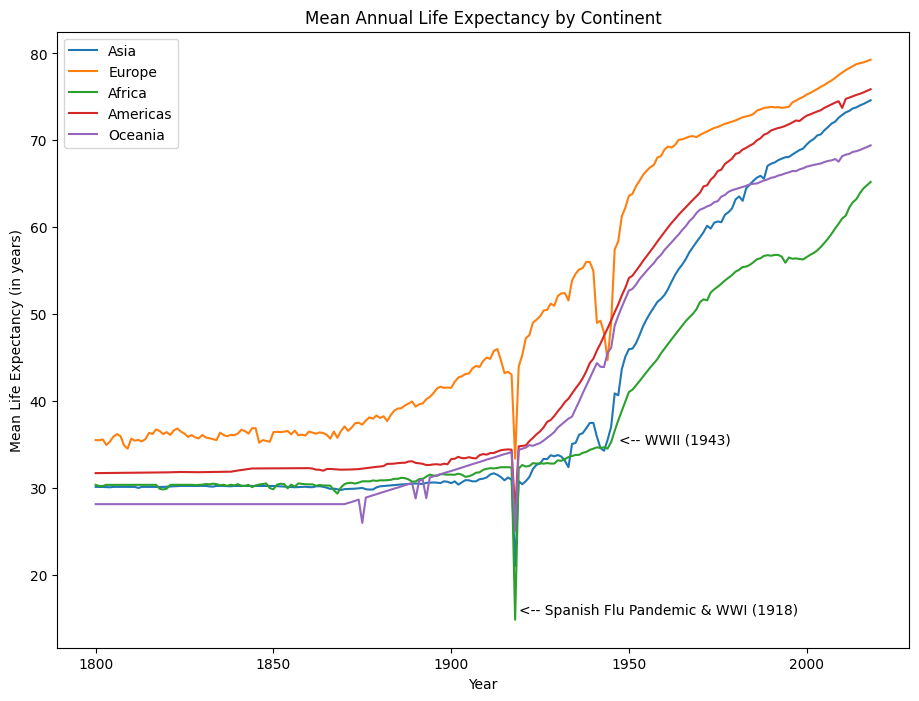

In [28]:
fig, ax = plt.subplots(figsize=(11,8))

for continent in gap['region'].unique():
    plt.plot(cont_life_exp_categories['year'], gap[gap['region'] == continent].groupby('year')['life_expectancy'].mean(), label=continent)
    
plt.title('Mean Annual Life Expectancy by Continent')
plt.xlabel('Year')
plt.ylabel('Mean Life Expectancy (in years)')
plt.annotate('<-- Spanish Flu Pandemic & WWI (1918)', (333, 24), xycoords='axes points')
plt.annotate('<-- WWII (1943)', (405, 147), xycoords='axes points');
plt.legend();

- All continents were jolted by the 1918 pandemic. 
- Europe and Asia look to have had sharp declines in the 1940s (probably WWII-related) that were not experienced as much in our other three continents. 
- We know that the United States participated in the war, but we likely aren't seeing that reflected in the plot above because 'Americas' also includes South-American countries that did not fight in WWII.

##### How has the mean population changed in each continent?

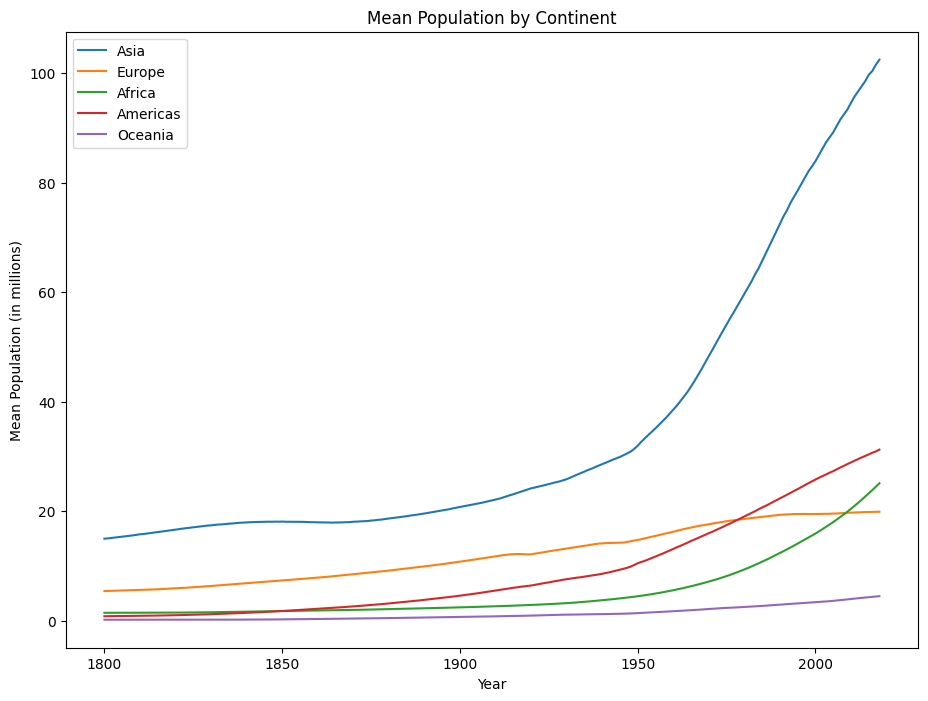

In [29]:
fig, ax = plt.subplots(figsize=(11,8))

for continent in gap['region'].unique():
    plt.plot(cont_life_exp_categories['year'], (gap[gap['region'] == continent].groupby('year')['population'].mean()/1_000_000), label=continent)
    
plt.title('Mean Population by Continent')
plt.xlabel('Year')
plt.ylabel('Mean Population (in millions)')
plt.legend();

- Asia has a much steeper incline in population than our other continents. 
- Europe's population growth appears to almost plateau in the 1970s. This may be part of the reason why it seems to have such a large jump in income; higher-income jobs without a significant expansion of its population means that money is distributed between fewer heads than in other continents.

---

#### Country

##### Which countries have the largest populations, on average?

In [30]:
pd.DataFrame(gap.groupby('geo')['population'].mean()).sort_values(by='population', ascending=False).head(10)

,population
geo,
China,606054794.521
India,409054794.521
United States,116386575.342
Russia,80878082.192
Indonesia,73561643.836
Japan,65352968.037
Germany,55485844.749
Brazil,52773972.603
Bangladesh,48520547.945


It appears that China has the highest mean population across all years included in the dataset. This is accurate, however, China's mean population (shown here for all years) is at just above 600 million.

There was a global population boom between 1950 and 1987, and China's current population sits at just under 1.5 billion (2021). 

We'll filter our data to include only the years after 1949 and therefore, better reflect modern-day population counts. 

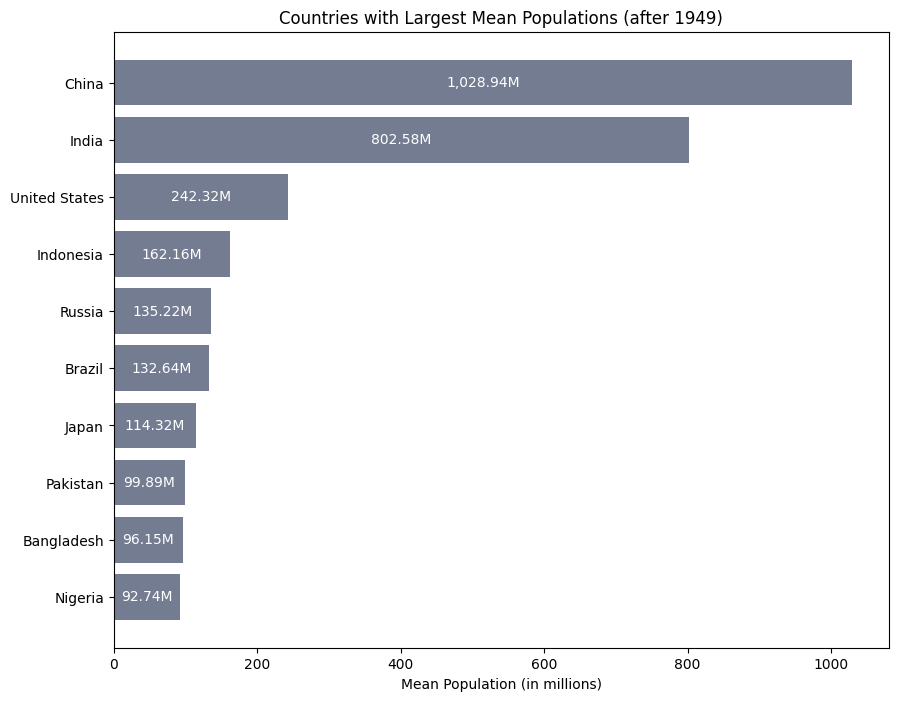

In [31]:
high_pop_countries = pd.DataFrame(gap[gap['year'] >= 1950].groupby('geo')['population'].mean()).sort_values(by='population', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,8))

high_pop_countr_plot = ax.barh(width = (high_pop_countries['population']/1_000_000)[::-1], y = high_pop_countries.index[::-1], color= '#747C92')
ax.bar_label(high_pop_countr_plot, labels= ["{:,.2f}".format(i) + 'M' for i in high_pop_countries['population']/1_000_000][::-1], label_type='center', color = 'white')
ax.set(title='Countries with Largest Mean Populations (after 1949)', xlabel='Mean Population (in millions)')
plt.show();

- China and India's mean populations dwarf the other countries in our plot, with a greater than 100% difference between their two respective values and the next-highest country on the list (United States).  
- We'll notice that there are no European countries on this list, supporting our earlier theory that if a country has a smaller population and a growing mean income, the overall average income per person will increase exponentially.

##### Which countries have the greatest mean income per person?

In [32]:
pd.DataFrame(gap.groupby(['geo', 'region'])['income_per_person'].mean()).sort_values(by='income_per_person', ascending=False).head(10)

,,income_per_person
geo,region,
Qatar,Asia,28745.205
United Arab Emirates,Asia,23861.772
Luxembourg,Europe,19307.215
Kuwait,Asia,19272.329
Switzerland,Europe,18092.740
United States,Americas,14573.927
Norway,Europe,14458.630
Saudi Arabia,Asia,13833.064
Netherlands,Europe,12824.110


- We can see here, when looking at mean income per person, that Asia makes up half of our top 10 countries. This is consistent with our prior 'Mean Income per Person by Continent' plot, and associated theory that a handful of high-income countries in Asia may be skewing the overall average. This is also true of our other continents.
- Europe is the second-most present continent, with four northern-European countries landing on our list.

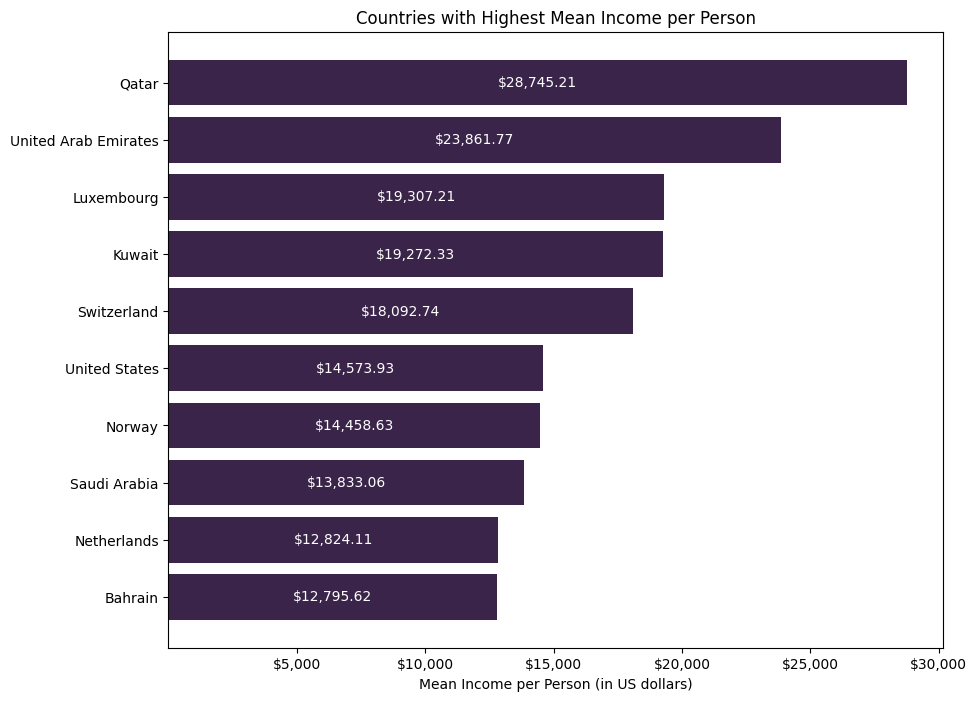

In [33]:
high_inc_countries = pd.DataFrame(gap.groupby('geo')['income_per_person'].mean()).sort_values(by='income_per_person', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,8))

high_inc_countr_plot = ax.barh(width = high_inc_countries['income_per_person'][::-1], y = high_inc_countries.index[::-1], color= '#3A2449')
ax.bar_label(high_inc_countr_plot, labels= ["${:,.2f}".format(i) for i in high_inc_countries['income_per_person']][::-1], label_type='center', color = 'white')
tick_vals = [5_000, 10_000, 15_000, 20_000, 25_000, 30_000]
ax.set(title='Countries with Highest Mean Income per Person', xlabel='Mean Income per Person (in US dollars)', xticks=tick_vals, xticklabels=['${:,.0f}'.format(i) for i in tick_vals])
plt.show();

##### How does the above list differ from our highest median income countries?

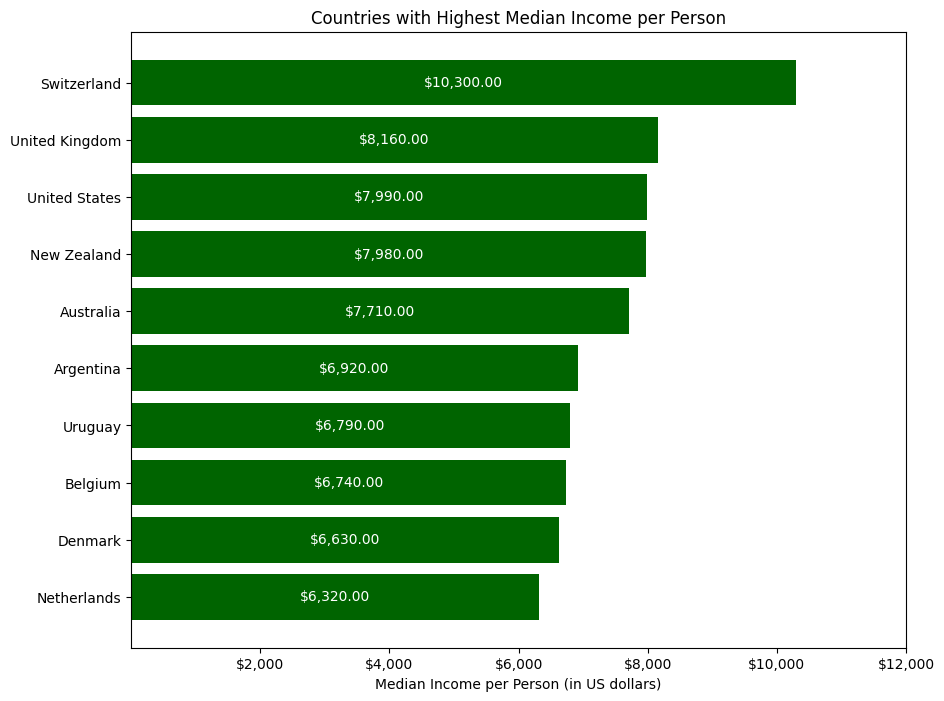

In [34]:
high_med_inc_countries = pd.DataFrame(gap.groupby('geo')['income_per_person'].median()).sort_values(by='income_per_person', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,8))

high_med_inc_country_plot = ax.barh(width = high_med_inc_countries['income_per_person'][::-1], y = high_med_inc_countries.index[::-1], color= 'darkgreen')
ax.bar_label(high_med_inc_country_plot, labels= ["${:,.2f}".format(i) for i in high_med_inc_countries['income_per_person']][::-1], label_type='center', color = 'white')
tick_vals = [2_000, 4_000, 6_000, 8_000, 10_000, 12_000]
ax.set(title='Countries with Highest Median Income per Person', xlabel='Median Income per Person (in US dollars)', xticks=tick_vals, xticklabels=['${:,.0f}'.format(i) for i in tick_vals])
plt.show();

- When we evaluate based on median, we can see that five of the high-income countries are in Europe. These are, again, a majority of the northern-European countries.
- The Americas are slightly more present here, with three countries landing in the top ten.
- We also see two new names on our plot: Australia and New Zealand.

##### How has the mean income per person for each of these countries changed over time?

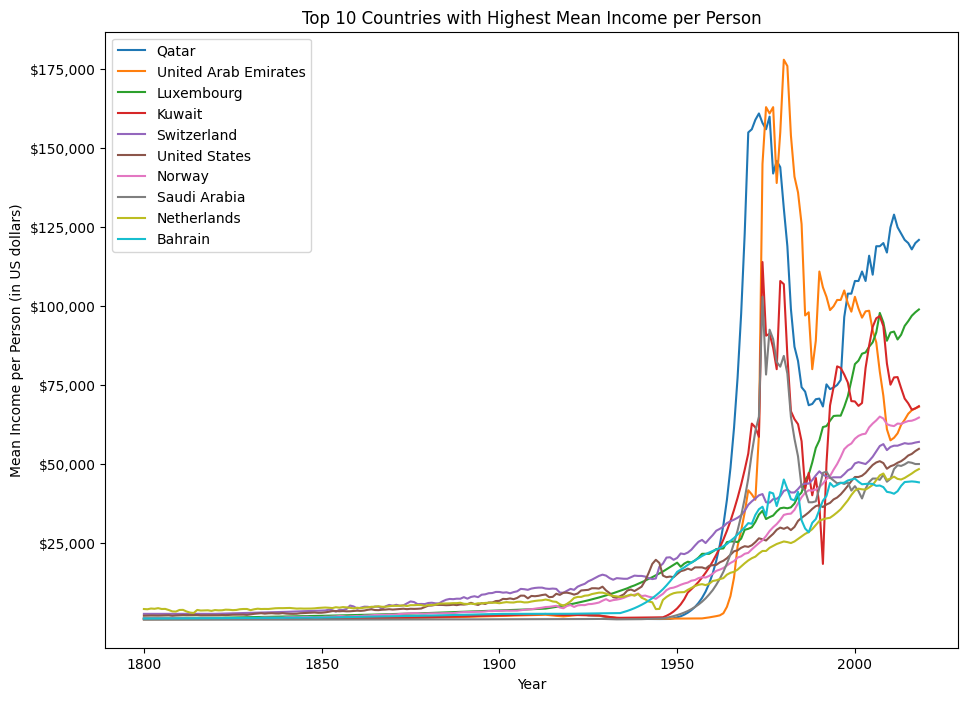

In [35]:
fig, ax = plt.subplots(figsize=(11,8))

for high_inc_country in list(high_inc_countries.index):
    plt.plot(cont_life_exp_categories['year'], gap[gap['geo'] == high_inc_country].groupby('year')['income_per_person'].mean(), label=high_inc_country)
    
plt.title('Top 10 Countries with Highest Mean Income per Person')
plt.xlabel('Year')
plt.ylabel('Mean Income per Person (in US dollars)')
tick_vals = [25_000, 50_000, 75_000, 100_000, 125_000, 150_000, 175_000]
plt.yticks(ticks= tick_vals, labels=['${:,.0f}'.format(i) for i in tick_vals])
plt.legend();

- None of the countries look to have experienced rapid growth until about 1960.
- The recession of the 1980s seems to have affected the countries located in Asia much more severly than in other continents. Qatar recovered stronger than others after the recession.

##### Do we see the same trends for median income per person?

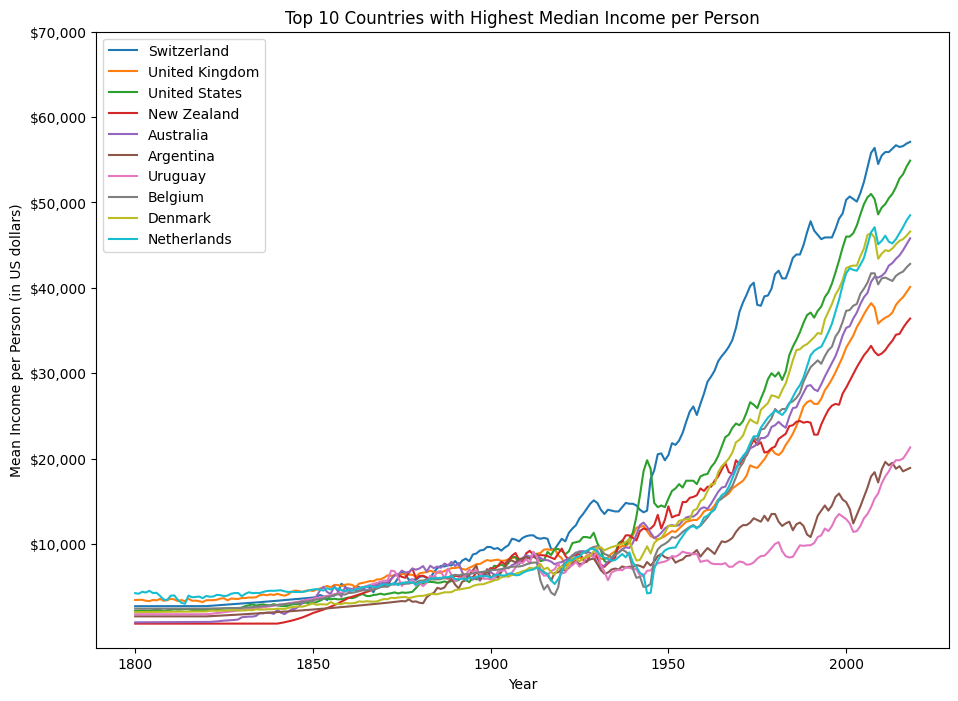

In [36]:
fig, ax = plt.subplots(figsize=(11,8))

for high_med_inc_country in list(high_med_inc_countries.index):
    plt.plot(cont_life_exp_categories['year'], gap[gap['geo'] == high_med_inc_country].groupby('year')['income_per_person'].mean(), label=high_med_inc_country)
    
plt.title('Top 10 Countries with Highest Median Income per Person')
plt.xlabel('Year')
plt.ylabel('Mean Income per Person (in US dollars)')
tick_vals = [10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000]
plt.yticks(ticks= tick_vals, labels=['${:,.0f}'.format(i) for i in tick_vals])
plt.legend();

- Our numbers are roughly cut in half when mapping median compared to mean income amounts.
- Most of the countries look to be have been affected by the three economic crises we mentioned earlier, though some more than others.

##### Which countries have the greatest average life expectancy?

In [37]:
high_life_exp_countries = pd.DataFrame(gap.groupby(['geo', 'region'])['life_expectancy'].mean()).sort_values(by='life_expectancy', ascending=False).head(10)
high_life_exp_countries

,,life_expectancy
geo,region,
Norway,Europe,59.727
Sweden,Europe,58.174
Denmark,Europe,57.531
Netherlands,Europe,56.191
Canada,Americas,56.037
United Kingdom,Europe,55.771
Switzerland,Europe,55.458
United States,Americas,54.845
Iceland,Europe,54.761


- The top life expectancies on our list are entirely made up of European and American countries. Again, Nordic countries have a strong showing at the top of our list.

##### How has life expectancy changed over time for the five countries with the highest overall means?

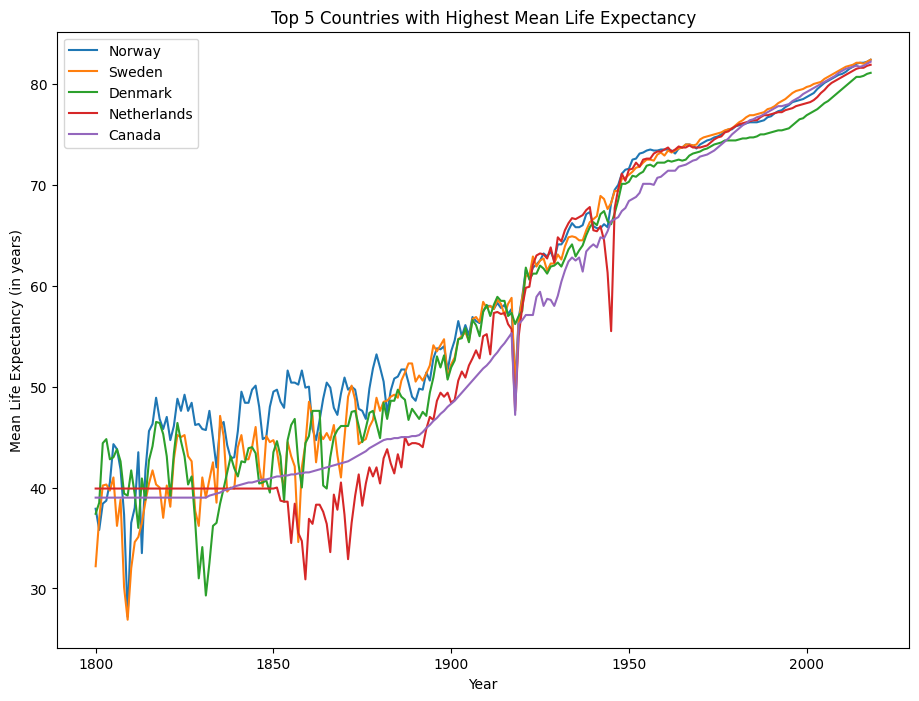

In [38]:
high_life_exp_countries = pd.DataFrame(gap.groupby('geo')['life_expectancy'].mean()).sort_values(by='life_expectancy', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(11,8))

for high_life_exp_country in list(high_life_exp_countries.index[0:5]):
    plt.plot(cont_life_exp_categories['year'], gap[gap['geo'] == high_life_exp_country].groupby('year')['life_expectancy'].mean(), label=high_life_exp_country)
    
plt.title('Top 5 Countries with Highest Mean Life Expectancy')
plt.xlabel('Year')
plt.ylabel('Mean Life Expectancy (in years)')
plt.legend();

- Unsurprisingly, our top five countries follow the same patterns in life expectancy seen in our global plot.
- All of the above, excluding Canada, had originally declared neutrality in WWII. They were all eventually occupied by one or both of the fighting sides, and inhabitants inenvitably lost their lives despite attempts to remain uninvolved.

---

#### EDA Conclusions

From our exploration of the data, we can see that there are clear relationships between our features. Most notably, a country's income per person in a given year is highly correlated with that country's average life expectancy. 

Population seems to have less sway on life expectancy, though we'll still be exploring this feature in our modeling. 

Because we don't have very many features - even with our engineered additions - we're unsure but hopeful about meeting the 80% accuracy goal outlined in our problem statement.